# NLP Project : Toxic comment detection
### Authors : Corentin ODIC & Michaël SOUMM

In this project, our goal will be to detect wether a comment left on a website may be "toxic", in the sence that it could be offensive or even dangerous. We propose to use the following kaggle database to work with : https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data. 

It contains over 2 million comments sampled from the Civil Comments platform, an open archive created so that researchers could understand and improve civility in online conversations for years to come.

Let us start by importing the database and our main modules :

## Various imports 

Downloading the database :

In [ ]:
!wget https://www.dropbox.com/s/sbiotru4wlr3ykj/train.csv.zip?dl=0 -O train.csv.zip
!unzip train.csv.zip

--2021-04-23 18:43:43--  https://www.dropbox.com/s/sbiotru4wlr3ykj/train.csv.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/sbiotru4wlr3ykj/train.csv.zip [following]
--2021-04-23 18:43:44--  https://www.dropbox.com/s/raw/sbiotru4wlr3ykj/train.csv.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc055eada1f92f3494890c484972.dl.dropboxusercontent.com/cd/0/inline/BNLU5793j0i4GJmnkZS5UuDycYb7kOEp_lSc09B2FexH8hZR3pnX4QV6ve6DdIUjZzxkqwAR01RxkSJkXk3RruuoN5zwXrcgabTeDzb6mZGUXai0nIFzxKaFra5KrbbhcuW7ViJcRPvIqlIlqfMZrE8b/file# [following]
--2021-04-23 18:43:44--  https://uc055eada1f92f3494890c484972.dl.dropboxusercontent.com/cd/0/inline/BNLU5793j0i4GJmnkZS5UuDycYb7kOEp_lSc09B2FexH8hZR3pnX4QV6ve6DdIUjZzxkqwAR01RxkSJkXk

Installing and importing modules :

In [ ]:
!pip install transformers -q
!pip install livelossplot -q

     |████████████████████████████████| 2.1MB 18.5MB/s 
     |████████████████████████████████| 3.3MB 55.4MB/s 
     |████████████████████████████████| 901kB 51.4MB/s 


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import plotly.figure_factory as ff
import pandas as pd
from tqdm import tqdm

from wordcloud import WordCloud, STOPWORDS

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, AutoModel, AutoTokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, classification_report

from livelossplot import PlotLosses

if torch.cuda.is_available():    
    print("Using GPU")
    device = torch.device("cuda")

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



Using GPU


## Description of the database

### Features

We can now load the database :

In [ ]:
df = pd.read_csv('train.csv')
df.head()

id    target  ... identity_annotator_count  toxicity_annotator_count
0  59848  0.000000  ...                        0                         4
1  59849  0.000000  ...                        0                         4
2  59852  0.000000  ...                        0                         4
3  59855  0.000000  ...                        0                         4
4  59856  0.893617  ...                        4                        47

[5 rows x 45 columns]

As we see, we have many interesting columns.

The main one is the `target`, which gives us a score for the toxicity. As a baseline taken from the Kaggle challenge, we consider a comment as toxic iff `target` $\geq$ 0.5. This column will be our main indicator.

In [ ]:
df['target'].isna().sum()

0

All the values are well defined.

Additionnaly, every toxic comment has a subtype score for: 
- severe_toxicity
- obscene
- threat
- insult
- identity_attack
- sexual_explicit

These help to mesure the type of toxicity we can be dealing with.

Finally, some toxic comments were labeled with an identity that has been cited in the text, within the following possibilities :
- male
- female
- transgender
- other_gender
- heterosexual
- homosexual_gay_or_lesbian
- bisexual
- other_sexual_orientation
- christian
- jewish
- muslim
- hindu
- buddhist
- atheist
- other_religion
- black
- white
- asian
- latino
- other_race_or_ethnicity
- physical_disability
- intellectual_or_learning_disability
- psychiatric_or_mental_illness
- other_disability



We will first train a model to predict the toxicity score of a comment, and then finetune it to see if we can predict other attributes.

### First simple analysis

We need to first understand the toxicity score and check if it can be simply explained. Let us look at the toxicity socre distribution :

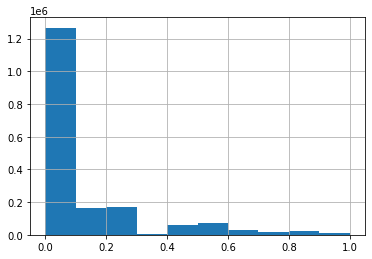

In [ ]:
df['target'].hist()

As we see, we have a big class imbalance that we will have to deal with later on.

We first check if there is a link between the toxicity and the polarity of a sentence, using `nltk`'s sentiment analysis:

In [ ]:
def polarity(x):
    if type(x) == str:
        return SIA.polarity_scores(x)
    else:
        return 1000
    
SIA = SentimentIntensityAnalyzer()
df["polarity"] = df["comment_text"].apply(polarity)

We check for a potential correlation by categorising the database into 4 types : 
- non toxic comments
- mildly toxic comments
- fairly toxic comments
- very toxic comments

In [ ]:
df["negativity"] = df["polarity"].apply(lambda x: x["neg"]).apply(lambda x: float(x))
 
nums_1 = df.sample(frac=0.1).query("target ==0")["negativity"]
nums_2 = df.sample(frac=0.1).query("target<= 0.33 and target>0")["negativity"]
nums_3 = df.sample(frac=0.1).query("target<= 0.66 and target>0.33")["negativity"]
nums_4 = df.sample(frac=0.1).query("target>0.66")["negativity"]

fig = ff.create_distplot(hist_data=[nums_1, nums_2, nums_3, nums_4],
                         group_labels=["Non toxique", "Peu toxique","Plutôt toxique","Très toxique"],
                         colors=["green","dodgerblue","darkorange","red"], show_hist=False)

fig.update_layout(title_text="Negativity vs. Toxicity", xaxis_title="Negativity", template="simple_white")
fig.show()


As we see, the more toxic a comment is, the more likely it to have a negative polarity. Nevertheless, the difference in the polarity is not that clear between our categories, meaning that toxicity detection will require a custom model.

Let us see a qualitative difference between toxic and non toxic comments : 

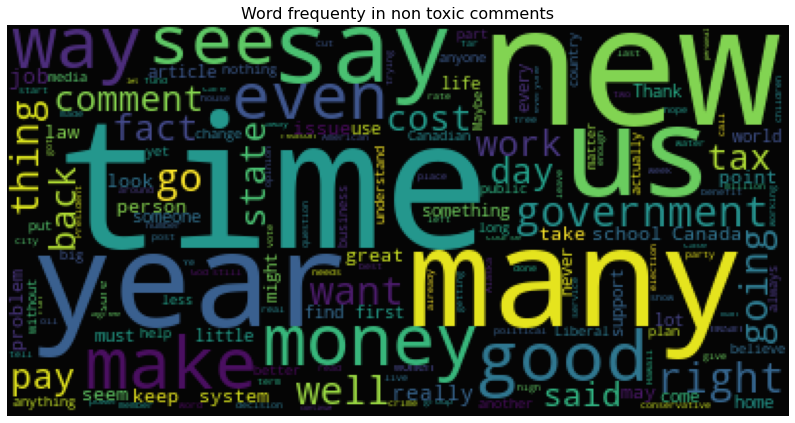

In [ ]:
# We add custom stopwords to our list
# We remove 'trump' because it appears the comments come from an election period
STOPWORDS.update({"Trump", "people", "will", "one", "know", "think", "now", "need", "much"})  
stopword = set(STOPWORDS)

df_wc = df.sample(frac=0.1)

subset = df_wc.query("target==0")
text   = subset.comment_text.values
wc     = WordCloud(background_color="black", max_words=2000, stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(14, 14))
plt.axis("off")
plt.title("Word frequenty in non toxic comments", fontsize=16)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98);

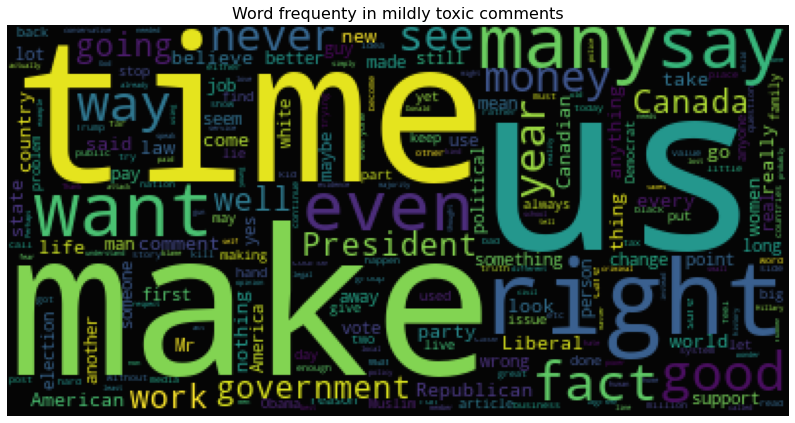

In [ ]:
subset = df_wc.query("target>0 and target<=0.33")
text = subset.comment_text.values
wc = WordCloud(background_color="black",max_words=1000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(14, 14))
plt.axis("off")
plt.title("Word frequenty in mildly toxic comments", fontsize=16)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98);

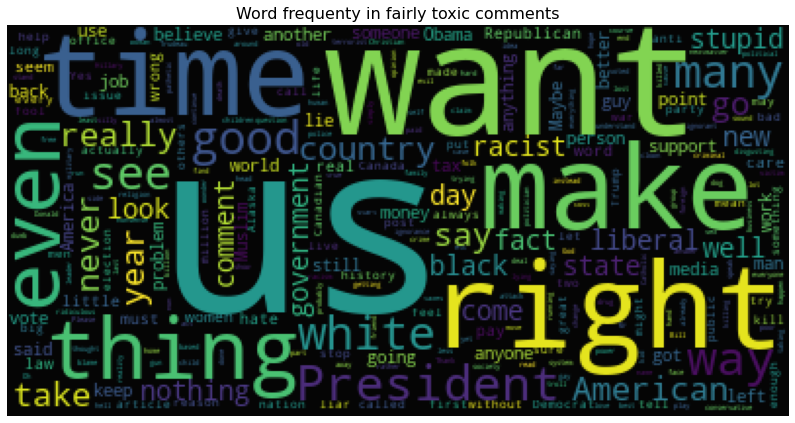

In [ ]:
subset = df_wc.query("target>0.33 and target<=0.66")
text = subset.comment_text.values
wc = WordCloud(background_color="black",max_words=1000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(14, 14))
plt.axis("off")
plt.title("Word frequenty in fairly toxic comments", fontsize=16)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98);

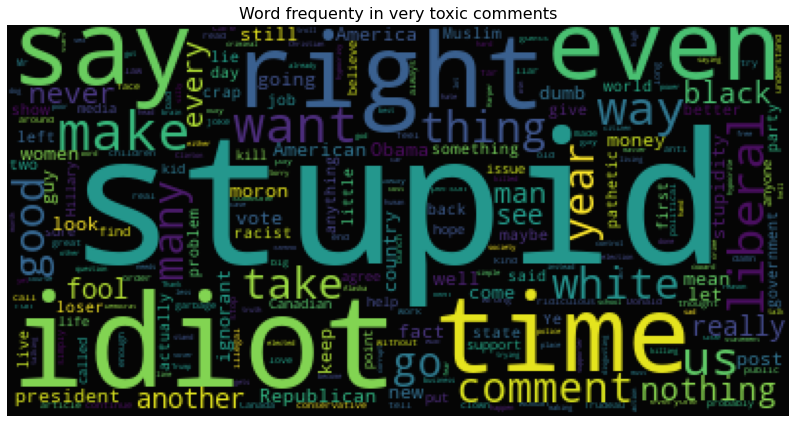

In [ ]:
subset = df_wc.query("target>0.66")
text = subset.comment_text.values
wc = WordCloud(background_color="black",max_words=1000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(14, 14))
plt.axis("off")
plt.title("Word frequenty in very toxic comments", fontsize=16)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98);

As we see, the toxic comments are truely composed of a different distribution of words.

## Toxicity prediction

### Preprocessing of the database

For our predictions, we will use transfer learning on BERT with finetunning. We will preprocess our database accordingly.

First of all, as we've seen, the data is quite unbalanced. Moreover, the dataset is way too big to train on a single GPU in an acceptable amount of time.

Therefore, we will limit ourselves to a subset of the original database, wich we will build with :
- 50% of toxic comments : `target` $\ge$ 0.5
- 25% of non toxic comments : `target`= 0
- 25% of mildly toxic comments : `target` $\in ]0,0.5[$

This construction may be debatable, but we came to the conclusion that is lead to a good diversity in our custom database. The fact that we have precisely 50% of toxic comments also gives us the possibility to easily monitor our training with an accuracy metric.

In [ ]:
df = pd.concat([df[df['target'] >= 0.5].sample(n=25000), 
                df[df['target'] == 0].sample(n=12500),
                df[df['target'].between(0, 0.5, inclusive=False)].sample(n=12500)])

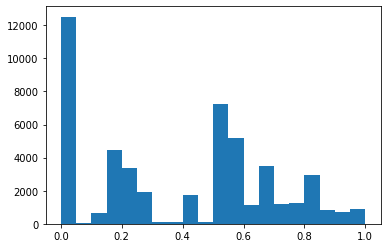

In [ ]:
sentences = df.comment_text.values
labels = df.target.values
plt.hist(labels, bins=20);

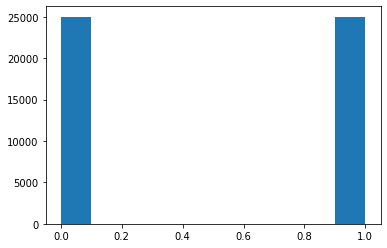

In [ ]:
plt.hist((labels>=0.5).astype(float));

We can now start a standart preprocessing for BERT. We start by initialising the tokenizer and applying it:

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
inputs = []

for sentence in tqdm(sentences, position=0):
    encoded_sent = tokenizer.encode(sentence,                  
                                    add_special_tokens = True # to have CLS/EOS/SEP tokens
                                    )
    
    inputs.append(encoded_sent)

100%|██████████| 50000/50000 [01:04<00:00, 776.58it/s]


Let us check the distribution of length in the comments : 

In [ ]:
print('Max sentence length: ', max([len(sen) for sen in inputs]))

Max sentence length:  283


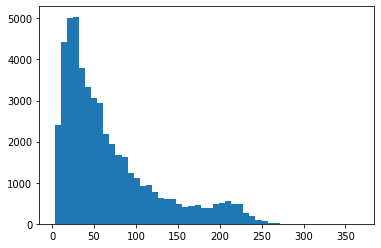

In [ ]:
sizes = [len(sen) for sen in inputs]
plt.hist(sizes, bins=50);

If we pad all our sentences to the maximum length, we will have memoty issues. We choose a maximum length of 128 tokens which conserves most comments while being computationnaly acceptable.

In [ ]:
inputs_idx = np.argwhere(np.array(sizes) <= 128)
clean_inputs = []
clean_labels = []

for i, input in enumerate(inputs):
    if sizes[i] <= 128:
        clean_inputs.append(input)
        clean_labels.append(labels[i])

In [ ]:
MAX_LEN = 128

clean_inputs = pad_sequences(clean_inputs, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

Finally, we create our attention masks for BERT training :

In [ ]:
attention_masks = []

for sent in clean_inputs:    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    attention_masks.append(att_mask)

Spliting the data into train/test and putting everything into dataloaders :

In [ ]:
# Use 80% for training and 20% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(clean_inputs, clean_labels, 
                                                            random_state=2021, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, clean_labels,
                                             random_state=2021, test_size=0.2)

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### Model

We use the base BERT model to generate our embedings. On top of that, we add 1 or 2 feedforward layers and use a final sigmoid to get scores in $[0,1]$:

In [ ]:
class ToxicPredictor(nn.Module):

    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(ToxicPredictor, self).__init__()
        
        #Loading Mask Language Model 
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)

        #we append extra layer for predicting toxicity  
        h = 1
        # for 2 hidden layers use :
        #h = 100
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(self.encoder.pooler.dense.out_features, h)
        #self.fc2 = nn.Linear(h, 1)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        cont_reps = self.encoder(seq, attention_mask = attn_masks)

        #Obtaining the representation of [CLS] head
        x = cont_reps["pooler_output"]
        x = self.dropout(x)
        x = self.fc1(x)
        # x = self.fc2(F.ReLU(x))

        return torch.sigmoid(x)

We then define our main train function :

In [ ]:
def train(model, criterion, opti, train_loader, val_loader, epochs=1):
    liveloss = PlotLosses()
    best_acc = 0

    for epoch in range(epochs):
        #########
        # Train #
        #########
        model.train()
        logs = {}
        tot_loss = 0
        correct  = 0
        for seq, attn_masks, labels in tqdm(train_loader, position=0, total=len(train_loader)):
            #Clear gradients
            opti.zero_grad()  

            #Converting these to cuda tensors
            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)
            
            # Getting prediction
            preds = model(seq, attn_masks).view(-1)

            #Computing loss
            loss = criterion(preds, labels.float())

            #Backpropagating the gradients
            loss.backward()
            tot_loss += loss.item()

            #Optimization step
            opti.step()

            # number of correct items
            true_toxic = (labels >= 0.5)
            pred_toxic = (preds  >= 0.5)

            correct += (true_toxic == pred_toxic).float().sum().item()

        # Show results
        logs['loss'] = tot_loss/len(train_loader.dataset)
        logs['accuracy'] = 100*correct/len(train_loader.dataset)

        ##############
        # Validation #
        ##############
        model.eval()  
        loss_val    = 0  
        correct_val = 0
        for seq, attn_masks, labels in tqdm(val_loader, position=0, total=len(val_loader)): 
            # Same as in train 

            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)
            
            preds_val = model(seq, attn_masks).view(-1)
        
            loss = criterion(preds_val, labels.float())
  
            loss_val += loss.item()

            true_toxic = (labels >= 0.5)
            pred_toxic = (preds_val >= 0.5)

            correct_val += (true_toxic == pred_toxic).float().sum().item()

        # Save the best model on validation
        acc = 100*correct_val/len(val_loader.dataset)
        if acc > best_acc:
            torch.save(model.state_dict(), "best_model.pth")
            best_acc = acc

        # Show results
        logs['val_loss'] = loss_val/len(val_loader.dataset)    
        logs['val_accuracy'] = acc

        liveloss.update(logs)
        liveloss.send()

Since we have a toxicity score in $[0,1]$ the natural loss is the binary cross-entropy:

In [ ]:
criterion = nn.BCELoss()

We first train the whole model, with different learning rates for the pretrained layers and our new ones :

In [ ]:
model = ToxicPredictor('bert-base-uncased').to(device)

opti = optim.Adam([{'params': model.fc1.parameters(),'lr': 1e-3}, 
                   {'params': model.encoder.parameters(), 'lr': 1e-5},
                   ])

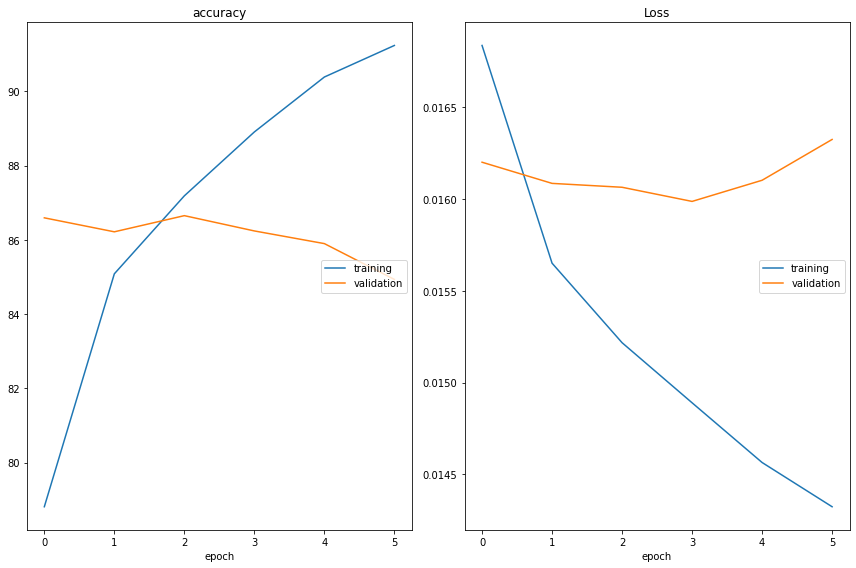

  0%|          | 0/1063 [00:00<?, ?it/s]

accuracy
	training         	 (min:   78.811, max:   91.233, cur:   91.233)
	validation       	 (min:   84.933, max:   86.650, cur:   84.933)
Loss
	training         	 (min:    0.014, max:    0.017, cur:    0.014)
	validation       	 (min:    0.016, max:    0.016, cur:    0.016)


 76%|███████▌  | 806/1063 [09:09<02:55,  1.47it/s]

KeyboardInterrupt: ignored

In [ ]:
train(model, criterion, opti, train_dataloader, validation_dataloader, epochs=20)

Even if the model has good performances, it clearly overfitted.

We have to check if we have the same results without overfitting by freesing the pretrained BERT encoder and using 2 final feedfoward layers :

In [ ]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [ ]:
model = ToxicPredictor('bert-base-uncased').to(device)

opti = optim.Adam([{'params': model.fc2.parameters(), 'lr': 1e-3},
                   {'params': model.fc1.parameters(), 'lr': 1e-3}, 
                   ])

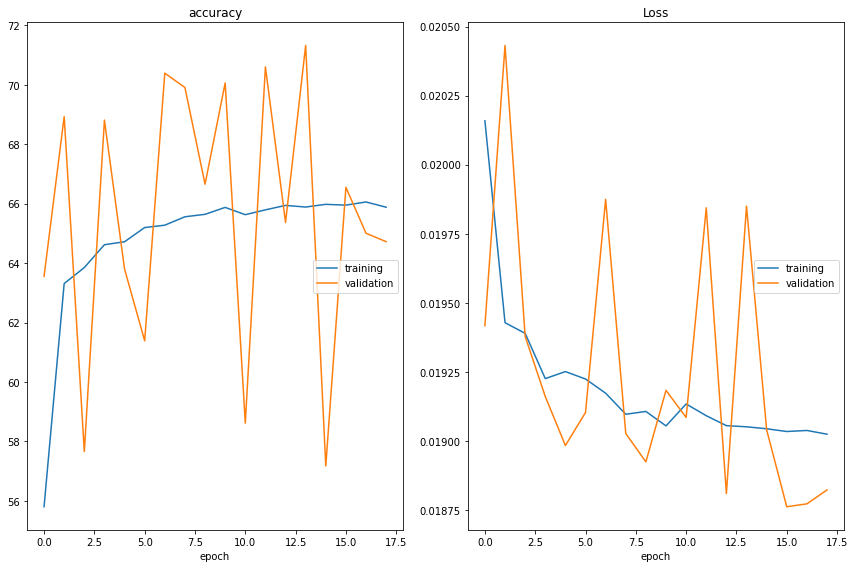

  0%|          | 0/1061 [00:00<?, ?it/s]

accuracy
	training         	 (min:   55.805, max:   66.058, cur:   65.881)
	validation       	 (min:   57.178, max:   71.322, cur:   64.722)
Loss
	training         	 (min:    0.019, max:    0.020, cur:    0.019)
	validation       	 (min:    0.019, max:    0.020, cur:    0.019)


 90%|████████▉ | 953/1061 [07:39<00:51,  2.08it/s]

In [ ]:
train(model, criterion, opti, train_dataloader, validation_dataloader, epochs=20)

The training is much more chaotic. We don't have overfitting but the results are much more worse even on the validation set.

Let us try a final test by training the last 2 feedforward layers, but also the final blocks of the BERT encoder (the pooler and and the last emmebeding block)

In [ ]:
for param in model.encoder.parameters():
    param.requires_grad = False

for param in model.encoder.pooler.parameters():
    param.requires_grad = True
for param in model.encoder.encoder.layer[11].parameters():
    param.requires_grad = True

In [ ]:
model = ToxicPredictor('bert-base-uncased').to(device)

opti = optim.Adam([{'params': model.fc2.parameters(),                       'lr': 1e-3},
                   {'params': model.fc1.parameters(),                       'lr': 1e-3}, 
                   {'params': model.encoder.pooler.parameters(),            'lr': 1e-4},
                   {'params': model.encoder.encoder.layer[11].parameters(), 'lr': 1e-4}


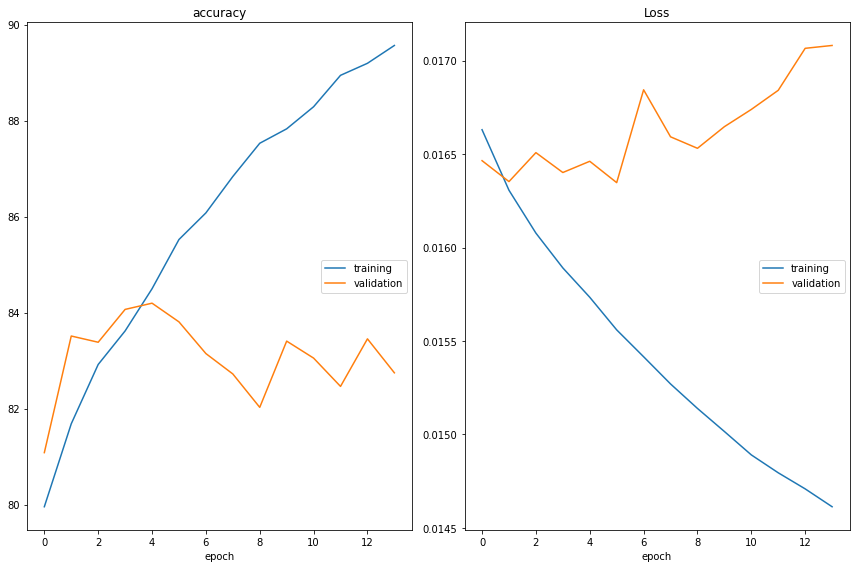

  0%|          | 0/1060 [00:00<?, ?it/s]

accuracy
	training         	 (min:   79.956, max:   89.565, cur:   89.565)
	validation       	 (min:   81.083, max:   84.196, cur:   82.746)
Loss
	training         	 (min:    0.015, max:    0.017, cur:    0.015)
	validation       	 (min:    0.016, max:    0.017, cur:    0.017)


 95%|█████████▌| 1009/1060 [08:31<00:25,  1.98it/s]

KeyboardInterrupt: ignored

In [ ]:
train(model, criterion, opti, train_dataloader, validation_dataloader, epochs=20)

We still have overfitting.

We choose to not continue to try to find exacly what layers to train. Even if the first model overfitted, the performances on the validation set are still very good, and if we keep trying to find the perfect trainable parameters we will end up overfitting the validation set.

To load the chosen model use :

In [ ]:
!wget https://www.dropbox.com/s/t3xtglkjlosj1uk/best_model.pth?dl=0 -O best_model.pth

--2021-04-23 18:46:30--  https://www.dropbox.com/s/t3xtglkjlosj1uk/best_model.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/t3xtglkjlosj1uk/best_model.pth [following]
--2021-04-23 18:46:31--  https://www.dropbox.com/s/raw/t3xtglkjlosj1uk/best_model.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0f183bd9e4dfe33ff9b152278c.dl.dropboxusercontent.com/cd/0/inline/BNKNJiFKtiUKnzFyyTbwK5jCFqTJ7X6duWx8mzp5G-TshkOPXUdrq5JAG3z6s8DbyrCjkScP6_sdQeVhBRCl3nP9rYC27VJJ9pscLdhux0r7nSkfp9adxpfvAtGdzMG6PM9NQmSmK33t8jh0Hz9WDN2C/file# [following]
--2021-04-23 18:46:31--  https://uc0f183bd9e4dfe33ff9b152278c.dl.dropboxusercontent.com/cd/0/inline/BNKNJiFKtiUKnzFyyTbwK5jCFqTJ7X6duWx8mzp5G-TshkOPXUdrq5JAG3z6s8DbyrCjkScP6_sdQeV

In [ ]:
model = ToxicPredictor('bert-base-uncased').to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

ToxicPredictor(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

### Qualitative results

Let us look at a few results from the trained model :

In [ ]:
seq, attn_masks, labels = next(iter(validation_dataloader))
preds = model(seq.to(device), attn_masks.to(device))

In [ ]:
for i in range(len(seq)):
    print("===============")
    print(tokenizer.decode(seq[i]))
    print("predicted", preds[i].item())
    print("real", labels[i].item())

[CLS] who gives a rats a about some clown in arizona? we got the real deal criminals running this town right here and now. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
predicted 0.6263288259506226
real 0.5
[CLS] " hawaii says the policy discriminates against muslims and hurts the state ’ s tourism - dependent economy. " bs! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

As we see, the predictions are quite impressive and we don't see any abnormalities. Nevertheless the model seems to have difficulties when the toxicity is exactly 0 (which is normal since most of the sigmoid outputs are way greater than 0).

### Quantitative results

In [ ]:
preds = []
binary_preds = []

model.to(device)
for seq, attn_masks, labels in tqdm(validation_dataloader, position=0, total=len(validation_dataloader)): 
    seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)

    preds_val = model(seq, attn_masks).view(-1).detach().cpu()
    preds += list(preds_val.float())
    binary_preds += list((preds_val >= 0.5).float())

100%|██████████| 267/267 [01:06<00:00,  4.03it/s]


In [ ]:
true = (validation_labels >= 0.5).float()
confusion_matrix(true, binary_preds)

array([[3707,  476],
       [ 611, 3723]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(true, binary_preds).ravel()
print("Precision:", tp/(tp+fp)*100)
print("Recall:", tp/(tp+fn)*100)

Precision: 88.66396761133603
Recall: 85.90216889709275


As we see, on this balanced dataset, we have a good confusion matrix with high precision and recall.

It would be interesting to see if the best theshold for our model is still 0.5. We can look at the ROC curve to evaluate the overall performance indepentely of this given threshold

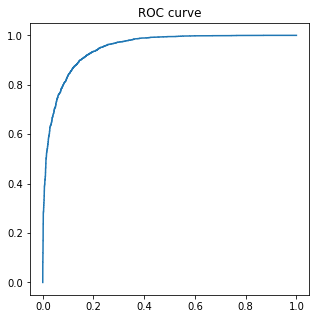

In [ ]:
fpr, tpr, _= roc_curve(true, preds)
plt.figure(figsize=(5,5))
plt.title("ROC curve")
plt.plot(fpr, tpr);

## Toxicity type prediction

Let us suppose that we can already predict if a comment is toxic or not. We want to predict the toxicity type.

In [ ]:
df = pd.read_csv('train.csv')
df = df[df['target'] >= 0.5]
df.head()

id    target  ... identity_annotator_count  toxicity_annotator_count
4    59856  0.893617  ...                        4                        47
5    59859  0.666667  ...                        0                       105
13  239583  0.600000  ...                        0                        10
14  239584  0.500000  ...                        0                        10
19  239592  0.500000  ...                        4                        10

[5 rows x 45 columns]

In [ ]:
df.isna().sum()

id                                         0
target                                     0
comment_text                               0
severe_toxicity                            0
obscene                                    0
identity_attack                            0
insult                                     0
threat                                     0
asian                                  98299
atheist                                98299
bisexual                               98299
black                                  98299
buddhist                               98299
christian                              98299
female                                 98299
heterosexual                           98299
hindu                                  98299
homosexual_gay_or_lesbian              98299
intellectual_or_learning_disability    98299
jewish                                 98299
latino                                 98299
male                                   98299
muslim    

First we will try to predict the type of the toxicity, since we have few features with all well-defined values.

In [ ]:
df = df[["comment_text", "obscene", "identity_attack", "insult", "threat"]]

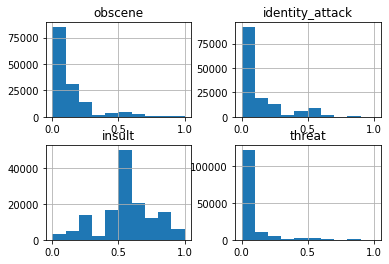

In [ ]:
df[["obscene", "identity_attack", "insult", "threat"]].hist();

As we see, most of the toxicity comes from the insults.

But here, we have a multi-class problem. This means that constucting a well-balanced dataset may be complicated. We start by considering the binary labels associated with each class :

In [ ]:
for name in ["obscene", "identity_attack", "insult", "threat"]:
    df['binary_'+name] = (df[name] >= 0.5)

In [ ]:
df

comment_text  ...  binary_threat
4                     haha you guys are a bunch of losers.  ...          False
5                                     ur a sh*tty comment.  ...          False
13       It's ridiculous that these guys are being call...  ...          False
14       This story gets more ridiculous by the hour! A...  ...          False
19       Angry trolls, misogynists and Racists", oh my....  ...          False
...                                                    ...  ...            ...
1804825  Who is the jerk in the last row between the C ...  ...          False
1804838  Nobody really cares that she supports the scie...  ...          False
1804856  Believing in God or not believing in God are p...  ...          False
1804857  I take your point, but I think you're shooting...  ...          False
1804872  Anyone who is quoted as having the following e...  ...          False

[144334 rows x 9 columns]

We want to construct our dataset by undersampling the most common combination of features, and oversampling the least common ones. The cleanest way to acheive this is to impletement MLSMOTE (SMOTE for multi-class), but we haven't found any simple implementation and hadn't anough time to re-implemenet it. 

One workaround is to create a `powerlabel`feature by combining the binaray labels of the 4 base features. This new label can thus take $2^4 = 16$ values.

In [ ]:
def power_label(x, features):
    label = 0
    for i, name in enumerate(features):
        label += 2**i * x["binary_"+name]
    return label
df['powerlabel'] = df.apply(lambda x: power_label(x, ["obscene", "identity_attack", "insult", "threat"]),axis=1)

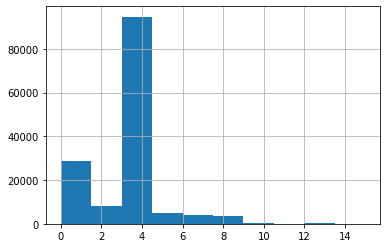

In [ ]:
df['powerlabel'].hist()

In [ ]:
df['powerlabel'].value_counts()

4     94647
0     24334
2      8005
5      4866
1      4162
6      3860
8      3408
12      397
7       263
10      212
13       61
14       52
9        32
3        26
15        8
11        1
Name: powerlabel, dtype: int64

To have enough diversity, we will try to not oversample a sentence more than ~10 times.
If a class has less than 2000 elements, we oversample it. If it has more than 2000 elements, we undersample it.

In [ ]:
df2 = pd.concat([df[df['powerlabel'].isin([4,0,2,5,1,6,8])].sample(n=7*2000),
                 df[df['powerlabel']==12].sample(n=3970, replace=True),
                 df[df['powerlabel']==7].sample(n=2630, replace=True),
                 df[df['powerlabel']==10].sample(n=2120, replace=True),
                 df[df['powerlabel']==13].sample(n=610, replace=True),
                 df[df['powerlabel']==14].sample(n=520, replace=True),
                 df[df['powerlabel']==9].sample(n=320, replace=True),
                 df[df['powerlabel']==3].sample(n=260, replace=True),
                 df[df['powerlabel']==15].sample(n=80, replace=True),
                 df[df['powerlabel']==11].sample(n=10, replace=True),
                ])


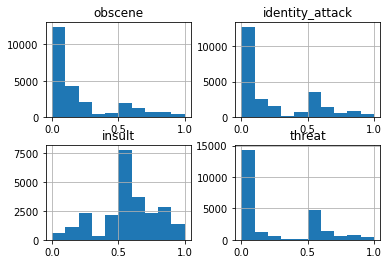

In [ ]:
df2[["obscene", "identity_attack", "insult", "threat"]].hist();

It looks like the imbalance has been a little bit reduced.

We re-run the same preprocessing that in the 1st part :

In [ ]:
sentences = df2.comment_text.values
labels = df2[["obscene", "identity_attack", "insult", "threat"]].values

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
inputs = []
for sentence in tqdm(sentences, position=0):
    encoded_sent = tokenizer.encode(sentence,                  
                                    add_special_tokens = True)
    inputs.append(encoded_sent)

sizes = [len(sen) for sen in inputs]
inputs_idx = np.argwhere(np.array(sizes) <= 128)
clean_inputs = []
clean_labels = []
for i, input in enumerate(inputs):
    if sizes[i] <= 128:
        clean_inputs.append(input)
        clean_labels.append(labels[i])
clean_inputs = pad_sequences(clean_inputs, maxlen=128, dtype="long", 
                          value=0, truncating="post", padding="post")

attention_masks = []
for sent in clean_inputs:    
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(clean_inputs, clean_labels, 
                                                            random_state=2021, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, clean_labels,
                                             random_state=2021, test_size=0.2)

100%|██████████| 24520/24520 [00:28<00:00, 852.61it/s]


In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### Model

We take the already trained model, since its embeddings should be adapted to our problem now. We just have to retrain the final layer and adapt it to our multi-label situation.

In [ ]:
in_features = model.fc1.in_features
model.fc1 = nn.Linear(in_features=in_features, out_features=4, bias=True).to(device)

In [ ]:
def train(model, criterion, opti, train_loader, val_loader, epochs=1):
    liveloss = PlotLosses()
    best_acc = 0

    for epoch in range(epochs):
        #########
        # Train #
        #########
        model.train()
        logs = {}
        tot_loss = 0
        correct  = torch.zeros(4)
        for seq, attn_masks, labels in tqdm(train_loader, position=0, total=len(train_loader)):
            #Clear gradients
            opti.zero_grad()  

            #Converting these to cuda tensors
            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)
            
            # Getting prediction
            preds = model(seq, attn_masks).view(-1,4)
            #Computing loss
            loss = criterion(preds, labels.float())

            #Backpropagating the gradients
            loss.backward()
            tot_loss += loss.item()

            #Optimization step
            opti.step()

            # number of correct items
            true_toxic = (labels >= 0.5)
            pred_toxic = (preds  >= 0.5)

            correct += (true_toxic == pred_toxic).float().sum(axis=0).detach().cpu()

        # Show results
        logs['loss'] = tot_loss/len(train_loader.dataset)
        for i, name in enumerate(["obscene", "identity_attack", "insult", "threat"]):
            logs['accuracy_'+name] = 100*correct[i]/len(train_loader.dataset)

        ##############
        # Validation #
        ##############
        model.eval()  
        loss_val    = 0  
        correct_val = torch.zeros(4)
        for seq, attn_masks, labels in tqdm(val_loader, position=0, total=len(val_loader)): 
            # Same as in train 

            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)
            
            preds_val = model(seq, attn_masks).view(-1,4)
            loss = criterion(preds_val, labels.float())
  
            loss_val += loss.item()

            true_toxic = (labels >= 0.5)
            pred_toxic = (preds_val >= 0.5)

            correct_val += (true_toxic == pred_toxic).float().sum(axis=0).detach().cpu()

        # Show results
        logs['val_loss'] = loss_val/len(val_loader.dataset) 
        for i, name in enumerate(["obscene", "identity_attack", "insult", "threat"]):
            logs['val_accuracy_'+name] = 100*correct_val[i]/len(val_loader.dataset)

        liveloss.update(logs)
        liveloss.send()

In [ ]:
criterion = nn.BCELoss()

for param in model.encoder.parameters():
    param.requires_grad = False

opti = optim.Adam([{'params': model.fc1.parameters(),'lr': 1e-3}
                   ])

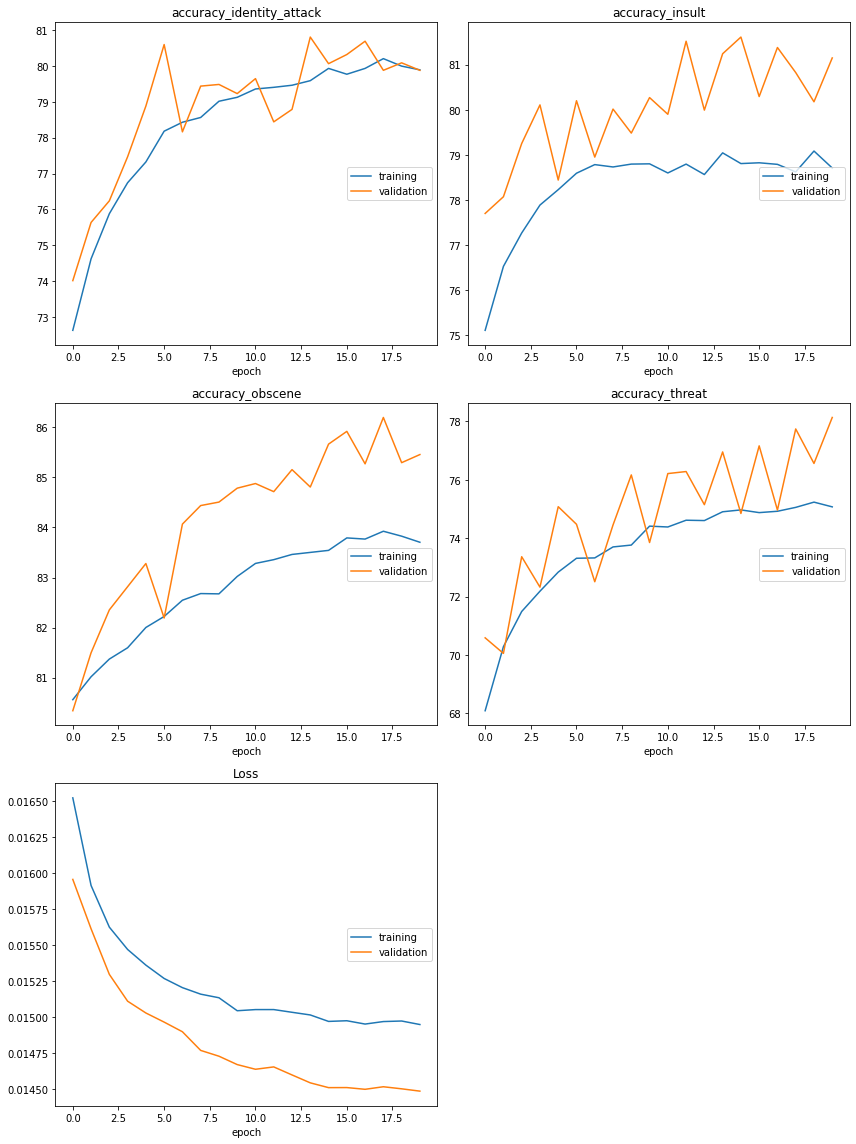

accuracy_identity_attack
	training         	 (min:   72.631, max:   80.200, cur:   79.888)
	validation       	 (min:   74.016, max:   80.801, cur:   79.875)
accuracy_insult
	training         	 (min:   75.104, max:   79.083, cur:   78.706)
	validation       	 (min:   77.698, max:   81.612, cur:   81.149)
accuracy_obscene
	training         	 (min:   80.559, max:   83.924, cur:   83.704)
	validation       	 (min:   80.338, max:   86.197, cur:   85.456)
accuracy_threat
	training         	 (min:   68.091, max:   75.237, cur:   75.075)
	validation       	 (min:   70.056, max:   78.138, cur:   78.138)
Loss
	training         	 (min:    0.015, max:    0.017, cur:    0.015)
	validation       	 (min:    0.014, max:    0.016, cur:    0.014)


In [ ]:
train(model, criterion, opti, train_dataloader, validation_dataloader, epochs=20)

We see very promising results, with no overfitting ah quite high accuracies. We will need to be carefull with these metrics since our dataset is not perfectly balanced.

### Qualitative results

In [ ]:
seq, attn_masks, labels = next(iter(validation_dataloader))
preds = model(seq.to(device), attn_masks.to(device))

In [ ]:
pd.set_option("display.precision", 2)
for i in range(len(seq)):
    print("\n======================================\n")
    print(tokenizer.decode(seq[i]).replace('[PAD]', '').replace('[CLS] ', ''))
    res = pd.DataFrame({'real': labels[i].tolist(), 'predicted':preds[i].tolist()}, index=["obscene", "identity_attack", "insult", "threat"])
    print(res)



this latest repub political gambit to sabotage the election of the first woman president is both stupid and tawdry at the same time. i was going to wait until election day to cast my ballot but i can't wait that long anymore. i'm compelled to vote for hillary clinton. it is time the voters dispatch this grotesque gargoyle back to his manhattan dragon's keep where he belongs. [SEP]                                           
                 real  predicted
obscene          0.03       0.09
identity_attack  0.03       0.03
insult           0.57       0.67
threat           0.02       0.10


don't tell your gop friends, i'm a moron? you voted for a con man, mexico will pay for the wall? he can't even do an executive order correctly, have fun. [SEP]                                                                                  
                 real  predicted
obscene          0.11       0.31
identity_attack  0.03       0.11
insult           0.62       0.71
threat           0.00       0.

As we see, the scores for `insult` seem to be pretty close to reality, and this was to be expected considering it is the most represented class. We see some constant abnormalities, such as an over-representation of threats. Identity attacks also seem to rarely be detected.

### Quantitative results

In [ ]:
preds = []
binary_preds = []

model.to(device)
for seq, attn_masks, labels in tqdm(validation_dataloader, position=0, total=len(validation_dataloader)): 
    seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)

    preds_val = model(seq, attn_masks).view(-1,4).detach().cpu()
    preds += preds_val.float().tolist()
    binary_preds += (preds_val >= 0.5).float().tolist()

100%|██████████| 135/135 [00:36<00:00,  3.75it/s]


In [ ]:
from sklearn.metrics import classification_report 
true = (validation_labels >=0.5).float().tolist()
print(classification_report(true, binary_preds, target_names=["obscene", "identity_attack", "insult", "threat"]))

                 precision    recall  f1-score   support

        obscene       0.77      0.36      0.49       845
identity_attack       0.92      0.29      0.45      1186
         insult       0.88      0.86      0.87      3178
         threat       0.92      0.39      0.55      1473

      micro avg       0.88      0.59      0.71      6682
      macro avg       0.87      0.48      0.59      6682
   weighted avg       0.88      0.59      0.68      6682
    samples avg       0.75      0.60      0.64      6682



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.



Just as we predicted, most of the accuracy comes from the most common class, `insult`, which has very good prediction scores. However, all the other classes have a very bad recall, even if the precision is quite high.